## 3.6 주택 가격 예측 : 회귀 문제

- 회귀 : 개별적인 레이블 대신에 연속적인 값을 예측  
ex. 기상 데이터가 주어졌을 때 내일 기온을 예측  


- 회귀 vs 로지스틱 회귀 : 로지스틱 회귀는 분류 알고리즘  

### 3.6.1 보스턴 주택 가격 데이터셋
: 1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율 등의 데이터가 주어졌을 때 주택 가격의 중간 값을 예측

In [37]:
import keras
keras.__version__

'2.3.1'

In [38]:
# 보스턴 주택 데이터셋 로드
from keras.datasets import boston_housing

(train_data, train_targets), (test_data,test_targets) = boston_housing.load_data()

In [39]:
train_data.shape # 샘플 개수 : 404, 수치 특성 개수 :13
                 # 여기서 특성은 1인당 범죄율, 주택당 평균 방의 개수, 고속도로 접근성 등

(404, 13)

In [40]:
test_data.shape # 샘플 개수 : 102, 수치 특성 개수 :13

(102, 13)

여기서 볼 수 있듯이 404개의 훈련 샘플과 102개의 테스트 샘플이 있고 모두 13개의 수치 특성을 가지고 있다. 13개의 특성은 다음과 같다:

1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.

In [41]:
train_targets # 주택의 중간 가격으로 천 달러 단위, 10000 ~ 50000 달러

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### 3.6.2 데이터 준비

- 특성의 스케일이 다르면 전역 최소 점을 찾아가는 경사 하강법의 경로가 스케일이 큰 특성에 영향을 많이 받는다. 그래서 이런 데이터를 다룰 때는 대표적인 방법으로 **특성별로 정규화**하는 것이다. 
- <u>입력 데이터에 있는 각 특성(입력 데이터 행렬의 열)에 대해서 특성의 평균을 빼고 표준 편차로 나눈다.</u>  
- 특성의 중앙이 0 근처에 맞추어지고 표준 편차는 1이 된다.  

In [42]:
# 데이터 정규화
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean # 테스트 데이터를 정규화할 때 사용한 값이 훈련 데이터에서 계산한 값이다!
test_data /= std

### 3.6.3 모델 구성

- 샘플 개수가 적기 때문에 64개의 유닛을 가진 2개의 은닉 층으로 작은 네트워크를 구성  
    - 입력층 : 데이터를 받아들이는 층
    - 은닉층 : 데이터를 한 번 이상 처리한 (가중치를 곱하고, 활성함수의 결과를 얻은) 노드로 구성된 층  
    - 출력층 : 최종 은닉층 또는 입력층에 가중치를 곱하고, 출력함수의 결과를 얻은 노드로 구성된 층  
    (출처 : https://yjjo.tistory.com/5)
- 일반적으로 훈련 데이터의 개수가 적을수록 과대적합이 더 쉽게 일어나므로 작은 모델을 사용하는 것이 과대적합을 피하는 한 방법이다.

In [43]:
# 모델 정의
from keras import models
from keras import layers

def build_model(): # 동일한 모델을 여러번 생성할 것이기 때문에 함수 만들어 사용
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                          input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) # 선형 층
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae']) 
    return model

이 네트워크의 마지막 층은 하나의 유닛을 가지고 있고 활성화 함수가 없다. 이것이 전형적인 스칼라 회귀(하나의 연속적인 값을 예측하는 회귀)를 위한 구성이다. 활성화 함수를 적용하면 출력 값의 범위를 제한하게 되지만 마지막 층이 순수한 선형이므로 네트워크가 어떤 범위의 값이라도 예측하도록 자유롭게 학습된다.

이 모델은 **mse 손실 함수**를 사용하여 컴파일한다. 이 함수는 <u>평균 제곱 오차의 약어로 예측과 타깃 사이 거리의 제곱</u>이다. 훈련하는 동안 모니터링을 위해 새로운 지표인 **평균 절대 오차(Mean Absolute Error, MAE)**를 측정한다. 이는 <u>예측과 타깃 사이의 거리의 절대값</u>이다.

### 3.6.4 K-겹 검증을 사용한 훈련 검증

**k-겹 교차 검증**  
- 데이터를 K개의 분할(폴드(fold))로 나누고(일반적으로 K=4, 5), K개의 모델을 각각 만들어 K-1개의 분할에서 훈련하고 나머지 분할에서 평가하는 방법이다.  
- 모델의 검증 점수는 K개의 검증 점수 평균이 된다.  
- 총 데이터 개수가 적은 데이터 셋에 대해 정확도를 향상시킬 수 있다.  
(참고 : https://m.blog.naver.com/ckdgus1433/221599517834, https://nonmeyet.tistory.com/entry/KFold-Cross-Validation%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D-%EC%A0%95%EC%9D%98-%EB%B0%8F-%EC%84%A4%EB%AA%85)  

<img src = 'https://tensorflowkorea.files.wordpress.com/2018/12/130.jpg'>  
<br>
<center>그림 : 3-겹 교차 검증</center>

In [44]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않는다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


- concatenate 함수 : 배열들을 연결해 배열 구하기 (참고 : https://icodebroker.tistory.com/5280)

In [45]:
all_scores # 검증 점수

[1.8810250759124756, 2.6877171993255615, 2.554131507873535, 2.2526843547821045]

In [46]:
np.mean(all_scores) # 평균

2.343889534473419

In [47]:
from keras import backend as K

# 메모리 해제
K.clear_session()

In [48]:
# 500 에포크 동안 훈련해서 각 에포크마다 모델이 얼마나 개선되었는지 에포크의 검증 점수로 파악
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않는다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    #mae_history = history.history['val_mean_absolute_error'] # 2.3.0 버전부터는 compile 메서드에 쓴 손실 이름을 그대로 사용
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [49]:
# K-겹 검증 점수 평균 기록
# 모든 폴드에 대해 에포크의 MAE 점수의 평균을 계산
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

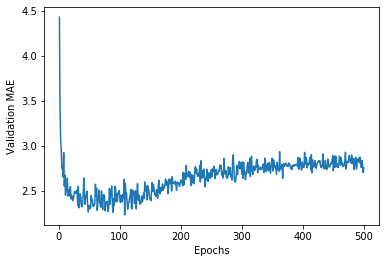

In [50]:
# 검증 점수 그래프
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

위의 그래프가 범위가 크고 변동이 심하기 때문에 다음과 같이 나타내보자.  
- 곡선의 다른 부분과 스케일이 많이 다른 첫 10개의 데이터 포인트를 제외시킨다.  
- 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 **지수 이동 평균**으로 대체한다.
    - 지수 이동 평균은 시계열 데이터를 부드럽게 만드는 기법 중 하나이다.  
    - 아래 코드에서 previous * factor + point * (1-factor) 합산한 것을 가리킨다.  

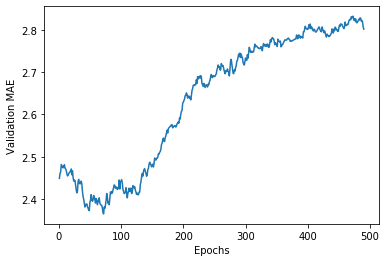

In [51]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:]) # 10개의 데이터 포인트 제외

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

- 위 그래프를 보면 검증 MAE가 80번째 에포크 이후에 줄어드는 것이 멈췄다. 이 지점 이후 과대적합이 시작된다.  
- 모델의 여러 매개변수에 대한 튜닝이 끝나면 모든 훈련 데이터를 사용하고 최상의 매개변수로 최종 실전에 투입될 모델을 훈련시킨 뒤 테스트 데이터로 성능을 확인한다.  

In [54]:
# 최종 모델 훈련
model = build_model() # 새롭게 컴파일된 모델을 얻는다
model.fit(train_data, train_targets,
         epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


In [55]:
test_mae_score # 2720달러 정도 차이

2.7200281620025635

### 3.6.5 정리
- 회귀는 분류에서 사용했던 것과는 다르 손실 함수를 사용한다. 평균 제곱 오차(MSE)는 회귀에서 자주 사용되는 손실 함수이다.  
- 비슷하게 회귀에서 사용되는 평가 지표는 분류와 다르다. 당연히 정확도 개념은 회귀에 적용되지 않는다. 일반적인 회귀 지표는 평균 절대 오차(MAE)이다.  
- 입력 데이터의 특성이 서로 다른 범위를 가지면 전처리 단계에서 각 특성을 개별적으로 스케일 조정해야 한다.  
- 가용한 데이터가 적다면 K-겹 검증을 사용하는 것이 신뢰할 수 있는 모델 평가 방법이다.  
- 가용한 훈련 데이터가 적다면 과대적합을 피하기 위해 은닉 층의 수를 줄인 모델이 좋다.(일반적으로 1개 또는 2개)
---

## 3.7 요약
- 이제 벡터 데이터를 사용하여 갖아 일반적인 머신 러닝인 이진 분류, 다중 분류, 스칼라 회귀 작업을 다룰 수 있다.  
- 보통 원본 데이터를 신경망에 주입하기 전에 전처리해야 한다.  
- 데이터에 범위가 다른 특성이 있다면 전처리 단계에서 각 특성을 독립적으로 스케일 조정해야 한다.  
- 훈련이 진행됨에 따라 신경망의 과대적합이 시작되고 새로운 데이터에 대해 나쁜 결과를 얻게 된다.  
- 훈련 데이터가 많지 않으면 과대적합을 피하기 위해 1개 또는 2개의 은닉 층을 가진 신경망을 사용한다.  
- 데이터가 많은 범주로 나뉘어 있을 때 중간층이 너무 작으면 정보의 병목이 생길 수 있다.  
- 회귀는 분류와 다르 손실 함수와 평가 지표를 사용한다.  
- 적은 데이터를 사용할 때는 K-겹 검증이 신뢰할 수 있는 모델 평가를 도와준다.  